In [1]:
import cv2
import gzip
import os
import pickle
from scipy.io import loadmat
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from tensorflow import keras
from matplotlib import pyplot as plt

class Data(object):
  """Will hold data set and some properties"""
  def __init__(self):
    self.x_train = []
    self.y_train = []
    self.x_val = []
    self.y_val = []
    self.x_test = []
    self.y_test = []
    self.num_train = 0
    self.num_test = 0
    self.num_val = 0
    self.x_test_orig = []
    self.label_dict = []
    self.dimension_dict = []
    self.batch_size = []

In [20]:
def load_svhn_and_preprocess(split):
  """load in svhn data and performs preprocessing

  The SVHN dataset is in a Matlab format.
  Need to load it in using scipy.io.loadmat
  When loading it in, will be a dict with items 'X' for the input
  images and 'y' for the labels.
  """
  print('WARNING!, have not implemented validation yet')
  print('Currently just using validation set as test set')
  dataset = Data()
  svhn_dir = os.path.join(os.environ['DATA_PATH'], 'svhn')
  # load in the SVHN data into dict objects
  svhn_train = loadmat(os.path.join(svhn_dir, 'train_32x32.mat'))
  svhn_test = loadmat(os.path.join(svhn_dir, 'test_32x32.mat'))
  # extract the input data and preprocess
  dataset.x_train = svhn_preprocess(svhn_train['X'])
  dataset.x_test = svhn_preprocess(svhn_test['X'])
  # extract the label data and one-hot encode it
  # included minus one as svhn dataset is labelled from [1, 10]
  # want to convert to [0, 9]
  # currently zero is stored as class 10, so will just replace
  # all the entries with a 10 as a zero
  y_train = svhn_train['y']
  y_test = svhn_test['y']
  y_train[y_train == 10] = 0
  y_test[y_test == 10] = 0
  dataset.y_train = keras.utils.to_categorical(y_train, 10)
  dataset.y_test = keras.utils.to_categorical(y_test, 10)
  # setting validation data to just be the same as the test data
  dataset.x_val = dataset.x_test
  dataset.y_val = dataset.y_test
  # creating the label_dict
  dataset.label_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
  # now create the dictionary to hold the dimensions of our data
  dataset.dimension_dict = {'in_dim' : 3072, 'out_dim' : 10, 'in_height': 32,
                    'in_width': 32, 'in_channels': 3}
  np.save(
    os.path.join(os.environ['DATA_PATH'], 'svhn_preprocessed', 'x_train.npy'),
    dataset.x_train)
  np.save(
    os.path.join(os.environ['DATA_PATH'], 'svhn_preprocessed', 'y_train.npy'),
    dataset.y_train)
  np.save(
    os.path.join(os.environ['DATA_PATH'], 'svhn_preprocessed', 'x_test.npy'),
    dataset.x_test)
  np.save(
    os.path.join(os.environ['DATA_PATH'], 'svhn_preprocessed', 'y_test.npy'),
    dataset.y_test)
  np.save(
    os.path.join(os.environ['DATA_PATH'], 'svhn_preprocessed', 'x_val.npy'),
    dataset.x_val)
  np.save(
    os.path.join(os.environ['DATA_PATH'], 'svhn_preprocessed', 'y_val.npy'),
    dataset.y_val)

  return dataset

In [21]:
def svhn_preprocess(svhn):
  """preprocessing of the street view house numbers dataset

  First reshape to correct dimensions and normalise.
  Then, further preprocessing is done using local contrast normalization
  in accordance with [1, 2].

  Args:
    svhn (np.array):
      street view house numbers dataset
  Returns:
    preprocessed svhn images

  References:
    [1] Sermanet, P., Chintala, S. and LeCun, Y., Convolutional Neural Networks
    Applied toHouse Numbers Digit Classification.
    [2] Zeiler, M. and Fergus, R., Stochastic Pooling for Regularization of Deep
    Convolutional Neural Networks
  """
  # swap the end axis to make the image index be the first dimension.
  # ie. go from [H, W, C, idx] to [idx, H, W, C]
  svhn = np.moveaxis(svhn, 3, 0)
  # now perform local contrast normalization
  svhn_normalized = local_contrast_normalization(svhn.astype(np.float32),
                                                       7, True)
  # apply global contrast normalization
  svhn_normalized = global_contrast_normalization(svhn_normalized)
  # now need to scale back to range [0, 1] so can convert back
  svhn_normalized = ((svhn_normalized - np.min(svhn_normalized)) /
                           (np.max(svhn_normalized) - np.min(svhn_normalized)))
  # just saving a test figure
  svhn = svhn
  plt.figure()
  plt.imshow(255 * svhn[0, ...].reshape([32, 32, 3]).astype(np.uint8))
  plt.savefig('./test.png')
  print('saved the figure')
  return svhn

In [22]:
def local_contrast_normalization(data, radius, use_divisor, threshold=1e-6):
  """ Applies LeCun local contrast normalization [1]

  Original code taken from [2] and modified for tensorflow usage

  Args:
    data (np.array):
      4D image data in RGB format, and first dim being batch
    radius (int)
      determines size of Gaussian filter patch
    use_divisor (bool):
      whether or not to apply divisive normalization
    threshold (float):
      the threshold will be used to avoid division by zeros

  Returns:
    4D array with local contrast normalization applied to each image

  References:
    [1] Jarret, K. etal, What is the Best Multi-Stage Architecture for
        Object Recognition?
    [2] https://github.com/jostosh/theano_utils/blob/master/lcn.py
  """
  # Get Gaussian filter
  filters = gaussian_filter(radius, 3)
  # Compute the Guassian weighted average by means of convolution
  convout = tf.nn.conv2d(data, filters, 1, "SAME")
  # subract from the original data
  centered = data - convout
  # Boolean marks whether or not to perform divisive step
  if use_divisor:
    # Note that the local variances can be computed by using the centered_X
    # tensor. If we convolve this with the mean filter, that should give us
    # the variance at each point. We simply take the square root to get our
    # denominator
    # Compute variances
    sum_sqr = tf.nn.conv2d(tf.math.square(centered), filters, 1, "SAME")
    # Take square root to get local standard deviation
    denom = tf.math.sqrt(sum_sqr)
    # find the mean of each image for each channel
    per_img_mean = np.mean(denom, axis=(1,2))
    # reshape the mean to go across all pixels so can compare
    per_img_mean = np.repeat(per_img_mean[..., np.newaxis], 32, axis=2)
    per_img_mean = np.repeat(per_img_mean[..., np.newaxis], 32, axis=3)
    # now swap the axis so the channel axis is on the end again
    per_img_mean = np.moveaxis(per_img_mean, 1, 3)
    divisor = tf.math.maximum(
      per_img_mean, tf.reshape(denom, [-1, data.shape[1], data.shape[2], 3]))
    # Divisise step
    new_X = centered / tf.math.maximum(divisor, threshold)
  else:
    new_X = centered
  return np.array(new_X)

In [23]:
def gaussian_filter(radius, channels):
  """create a Gaussian filter to be applied to a batch of images

  Args:
    radius (int):
      square size of rhe kernel
    channels (int):
      the number of channels of Gaussian kernels

  Returns:
    Gaussian kernel of size [1, radius, radius, channels]
  """
  # creating a 2d Gaussian
  x, y = np.meshgrid(np.linspace(-1, 1, radius), np.linspace(-1 ,1 ,radius))
  d = np.sqrt(x * x + y * y)
  sigma, mu = 1.0, 0.0
  gaussian_2d = np.exp(- ((d-mu)**2 / ( 2.0 * sigma**2 )))
  print(gaussian_2d.shape)
  # repeat for all the channels
  gaussian_2d = gaussian_2d.reshape([radius, radius, 1])
  gaussian_3d = np.repeat(gaussian_2d[..., np.newaxis], channels, axis=3)
  print('here')
  print(gaussian_3d.shape)
  # then reshape to add a batch dimension of one, then return
  return gaussian_3d#reshape([1, *gaussian_3d.shape])

In [24]:
def global_contrast_normalization(data, s=1, lmda=10, epsilon=1e-8):
  """ from
  https://datascience.stackexchange.com/questions/15110/how-to-implement-global-contrast-normalization-in-python"""
  for img_idx in range(0, data.shape[0]):
    for channel_idx in range(0, data.shape[3]):
      X_average = np.mean(data[img_idx, :, :, channel_idx])
      X = data[img_idx, :, :, channel_idx] - X_average
      # `su` is here the mean, instead of the sum
      contrast = np.sqrt(lmda + np.mean(X**2))
      data[img_idx, :, :, channel_idx] = s * X / np.maximum(contrast, epsilon)
  return data


WARNING!, have not implemented validation yet
Currently just using validation set as test set
(7, 7)
here
(7, 7, 1, 3)
saved the figure
(7, 7)
here
(7, 7, 1, 3)
saved the figure


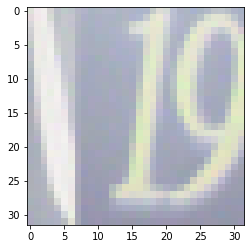

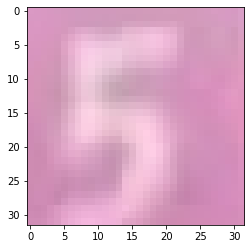

In [25]:
dataset = load_svhn_and_preprocess('')

In [29]:
ind = np.where(np.argmax(dataset.y_test, axis=1) == 0)
print(ind[0])

[    3    21    34 ... 26006 26011 26021]


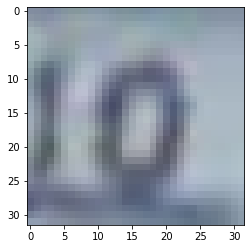

In [30]:
plt.imshow(dataset.x_test[ind[0][0], ...])

/home/xxxxxx/tf2_4/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


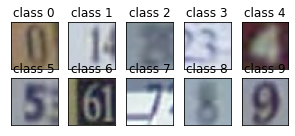

In [34]:
plt.figure(figsize=(5, 5))
n = 10
for i in range(n):
    ind = np.where(np.argmax(dataset.y_test, axis=1) == i)[0][20]
    # display original
    ax = plt.subplot(n/2, n/2, i + 1)
    plt.imshow(dataset.x_test[ind, ...].reshape(32, 32, 3))
    ax.set_title('class {}'.format(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()